## **Dataset Creation & Description**


The following is a custom torch.utils.data.Dataset for loading paired 64mT and 3T brain MRI scans from [Paired 64mT and 3T Brain MRI Scans of Healthy Subjects for Neuroimaging Research](https://zenodo.org/records/15471394).

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive')

# Install MONAI and libraries
# Nilearn only needed for viewing as nii.gz type
# Monai needed for transformations
!pip install monai nibabel nilearn

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.7/12.7 MB 99.9 MB/s eta 0:00:00


### **Displaying MRIs**


In [ ]:
from pathlib import Path
import nilearn.plotting
import nilearn.image
from IPython.display import display

nifti_path_HF = Path('/content/drive/MyDrive/Data') / '3T data' / 'sub-0011' / 'anat' / 'sub-0011_acq-highres_FLAIR.nii.gz'
nifti_path_LF = Path('/content/drive/MyDrive/Data') / '64mT data' / 'sub-0011' / 'ses-01' / 'anat' / 'sub-0011_ses-01_run-1_T1w.nii.gz'

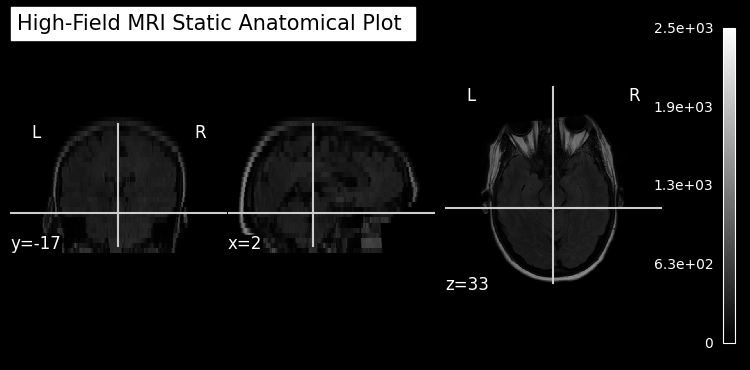

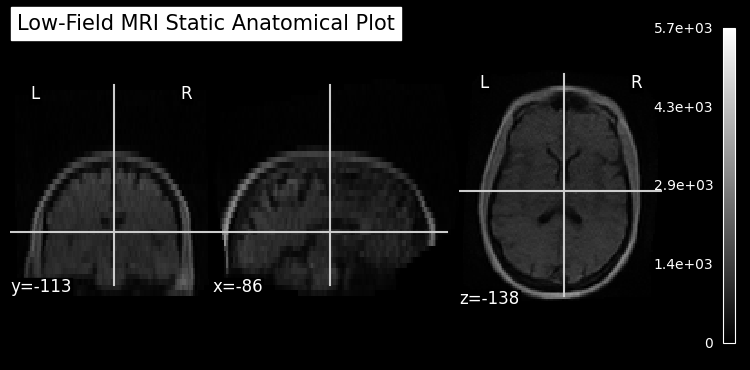

In [ ]:
nilearn.plotting.plot_anat(nifti_path_HF, title="High-Field MRI Static Anatomical Plot ")
nilearn.plotting.plot_anat(nifti_path_LF, title="Low-Field MRI Static Anatomical Plot")


In [ ]:
v1 = nilearn.plotting.view_img(nifti_path_HF, title="Interactive HF MRI NIfTI Viewer")
v2 = nilearn.plotting.view_img(nifti_path_LF, title="Interactive LF MRI NIfTI Viewer")

/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/lib/python3.12/dist-packages/numpy/_core/fromnumeric.py:820: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



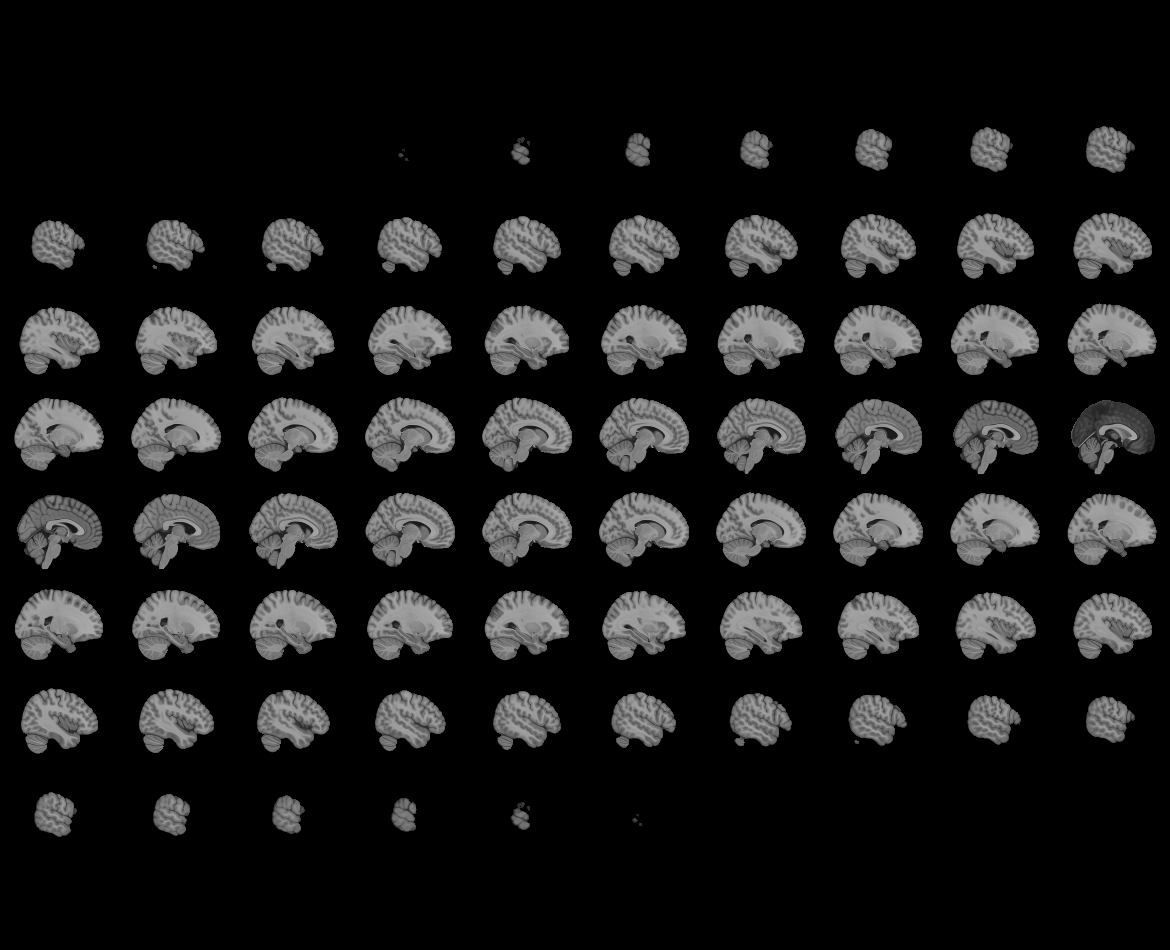
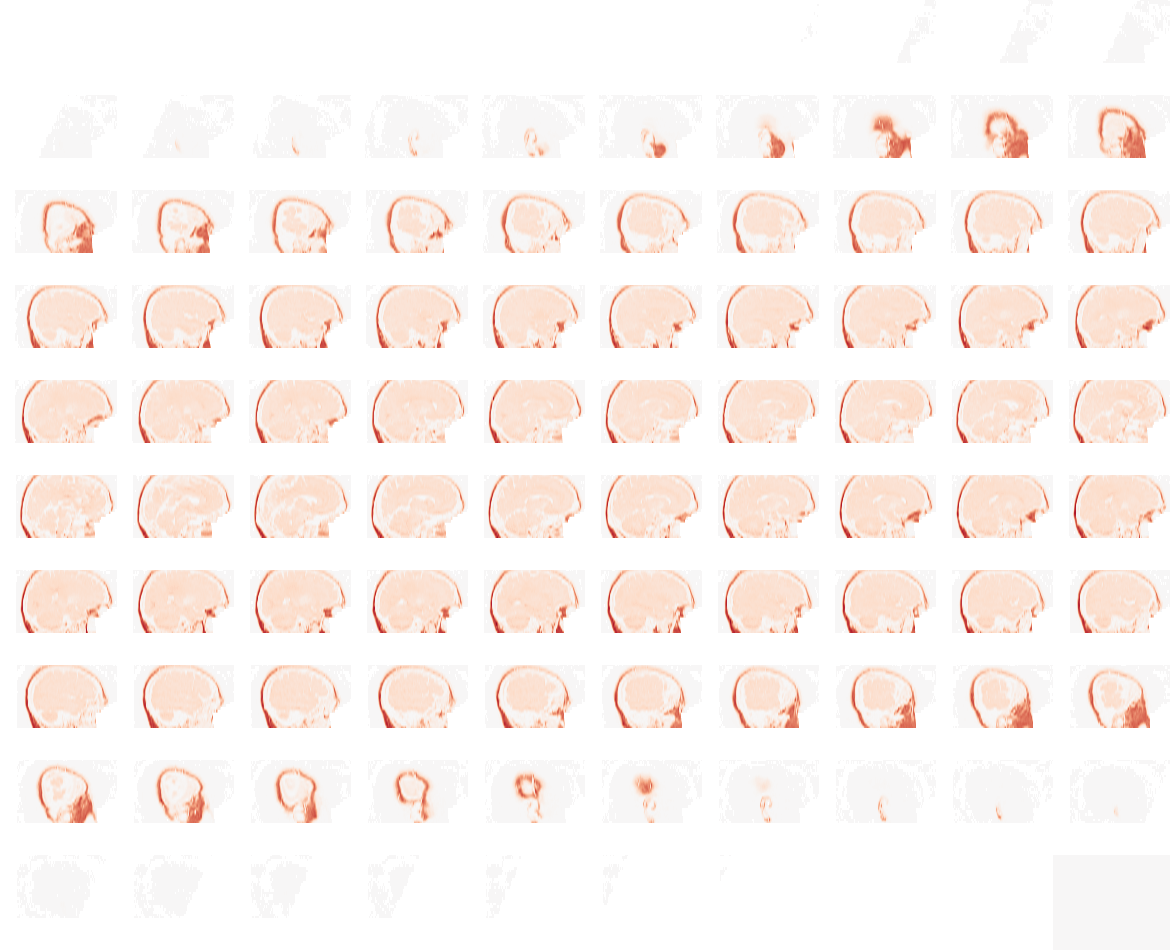

In [ ]:
display(v1)


### **Analysis of the Dataset**

In [ ]:
import os
from pathlib import Path
from collections import defaultdict
import re

# Assuming your data is at this path. Change it if necessary.
data_dir = Path('/content/drive/MyDrive/Data')
lr_dir = data_dir / '64mT data'
hr_dir = data_dir / '3T data'

def get_subjects_and_sessions(root_dir):
    """
    Scans a BIDS-like directory and returns a dictionary:
    {subject_id: {session_id: [list of anat files]}}
    """
    subjects = {}
    if not root_dir.exists():
        return subjects

    for subject_path in root_dir.glob('sub-*'):
        if not subject_path.is_dir(): continue
        sub_id = subject_path.name
        subjects[sub_id] = {}

        # Handle both session folders and direct anat folders (though BIDS prefers sessions)
        sessions = list(subject_path.glob('ses-*'))
        if not sessions:
             # Check for direct 'anat' if no session folders exist
             anat_dir = subject_path / 'anat'
             if anat_dir.exists():
                 subjects[sub_id]['no_session'] = [f.name for f in anat_dir.glob('*.nii.gz')]
        else:
            for session_path in sessions:
                if not session_path.is_dir(): continue
                ses_id = session_path.name
                anat_dir = session_path / 'anat'
                if anat_dir.exists():
                    subjects[sub_id][ses_id] = [f.name for f in anat_dir.glob('*.nii.gz')]
                else:
                    subjects[sub_id][ses_id] = [] # Session exists but no anat data
    return subjects

# --- 1. Scan Directories ---
print("Scanning 64mT data...")
lr_data = get_subjects_and_sessions(lr_dir)
print(f"Found {len(lr_data)} subjects in 64mT data.")

print("\nScanning 3T data...")
hr_data = get_subjects_and_sessions(hr_dir)
print(f"Found {len(hr_data)} subjects in 3T data.")


# --- 2. Analyze Subjects & Sessions ---
lr_subjects = set(lr_data.keys())
hr_subjects = set(hr_data.keys())

# Question 1: How many subjects have more than one 64mT session?
multi_session_64mT = {sub: sessions for sub, sessions in lr_data.items() if len(sessions) > 1}
print(f"\n--- Session Analysis ---")
print(f"Subjects with >1 session in 64mT: {len(multi_session_64mT)}")
# --- MODIFICATION START ---
if len(multi_session_64mT) > 0:
    print(f"IDs: {list(multi_session_64mT.keys())}")
# --- MODIFICATION END ---


# --- Run Analysis (64mT) ---
# Question: For 64mT, how many subjects have more than one run?
run_pattern = re.compile(r'run-(\d+)')
subjects_one_run = []
subjects_multi_run = []

for sub_id, sessions in lr_data.items():
    all_files = []
    for ses_files in sessions.values():
        all_files.extend(ses_files)

    found_multiple_runs = False
    for f in all_files:
        matches = run_pattern.findall(f)
        for run_num_str in matches:
            if int(run_num_str) > 1:
                found_multiple_runs = True
                break
        if found_multiple_runs:
            break

    if found_multiple_runs:
        subjects_multi_run.append(sub_id)
    else:
        subjects_one_run.append(sub_id)

print(f"\n--- Run Analysis (64mT) ---")
print(f"Subjects with only one run (or no 'run' tag): {len(subjects_one_run)}")
print(f"Subjects with more than one run (e.g., 'run-2'): {len(subjects_multi_run)}")
# --- MODIFICATION START ---
if len(subjects_multi_run) > 0:
    print(f"IDs: {subjects_multi_run}")
# --- MODIFICATION END ---


# --- Subject Overlap Analysis ---
only_in_64mT = lr_subjects - hr_subjects
only_in_3T = hr_subjects - lr_subjects
in_both = lr_subjects & hr_subjects

print(f"\n--- Subject Overlap Analysis ---")
print(f"Subjects in BOTH 64mT and 3T: {len(in_both)}")
print(f"Subjects ONLY in 64mT: {len(only_in_64mT)}")
print(f"Subjects ONLY in 3T: {len(only_in_3T)}")


# --- Acquisition Analysis ---
def analyze_acquisitions(data_dict, scanner_name):
    both_acq = 0
    only_high = 0
    only_low = 0
    neither_or_other = 0

    for sub_id, sessions in data_dict.items():
        # Aggregate all files across all sessions for a subject to see overall availability
        all_files = []
        for ses_files in sessions.values():
            all_files.extend(ses_files)

        has_high = any('acq-highres' in f for f in all_files)
        has_low = any('acq-lowres' in f for f in all_files)

        if has_high and has_low:
            both_acq += 1
        elif has_high and not has_low:
            only_high += 1
        elif not has_high and has_low:
            only_low += 1
        else:
            neither_or_other += 1 # Might have files without 'acq-' tag

    print(f"\n--- Acquisition Analysis for {scanner_name} ---")
    print(f"Total Subjects: {len(data_dict)}")
    print(f"Subjects with BOTH HighRes & LowRes: {both_acq}")
    print(f"Subjects with ONLY HighRes: {only_high}")
    print(f"Subjects with ONLY LowRes: {only_low}")
    if neither_or_other > 0:
        print(f"Subjects with neither (or standard naming): {neither_or_other}")

analyze_acquisitions(hr_data, "3T")

Scanning 64mT data...
Found 65 subjects in 64mT data.

Scanning 3T data...
Found 11 subjects in 3T data.

--- Session Analysis ---
Subjects with >1 session in 64mT: 12
IDs: ['sub-0045', 'sub-0057', 'sub-0028', 'sub-0063', 'sub-0058', 'sub-0046', 'sub-0015', 'sub-0001', 'sub-0027', 'sub-0026', 'sub-0012', 'sub-0025']

--- Run Analysis (64mT) ---
Subjects with only one run (or no 'run' tag): 60
Subjects with more than one run (e.g., 'run-2'): 5
IDs: ['sub-0028', 'sub-0046', 'sub-0021', 'sub-0048', 'sub-0008']

--- Subject Overlap Analysis ---
Subjects in BOTH 64mT and 3T: 11
Subjects ONLY in 64mT: 54
Subjects ONLY in 3T: 0

--- Acquisition Analysis for 3T ---
Total Subjects: 11
Subjects with BOTH HighRes & LowRes: 11
Subjects with ONLY HighRes: 0
Subjects with ONLY LowRes: 0


### **Get the paired paths**

In [ ]:
import os
from pathlib import Path

def get_data_dicts(data_dir):
  lr_dir = data_dir / '64mT data'
  hr_dir = data_dir / '3T data'

  data_dicts = []

  print("Scanning for data...")
  for subject_dir in lr_dir.glob('sub-*'):
      subject_id = os.path.basename(subject_dir)
      #print(f" ---- SUBJECT {subject_id} ---- ")
      sess_dirs = list(subject_dir.glob('ses-*'))
      session_dir = False if not sess_dirs else sess_dirs[0]
      if session_dir:
          anat_dir = session_dir / 'anat'

          # Find the NIfTI file in the LR anat folder
          # Use .search() if you know the suffix, or .glob()
          lr_files = list(anat_dir.glob('*T1w.nii.gz'))
          if not lr_files:
              continue # Skip if no NIfTI file

          lr_nifti_path = lr_files[0]
          hr_name = f"{subject_id}_acq-highres_T1w.nii.gz"
          hr_nifti_path = hr_dir / subject_dir.name / 'anat' / hr_name

          # Only add the pair if the high-res file also exists
          if hr_nifti_path.exists():
              subject = {
                  'lr': str(lr_nifti_path),
                  'hr': str(hr_nifti_path)
              }
              data_dicts.append(subject)
  return data_dicts


data_dir = Path('/content/drive/MyDrive/Data')

data_dicts = get_data_dicts(data_dir)
print(f"Found {len(data_dicts)} paired scans.")

Scanning for data...
Found 11 paired scans.


### **Dataset Class**

In [ ]:
import os
import torch
import numpy as np
from pathlib import Path
from torch.utils.data import Dataset, DataLoader

from monai.transforms import (
    Compose,
    LoadImageD,
    EnsureChannelFirstd,
    OrientationD,
    ScaleIntensityRangeD,
    ToTensorD
)

In [ ]:
class PairedMRIDataset(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root_dir = Path(root_dir)
        self.transform = transform

        self.file_pairs = get_data_dicts(root_dir)

        if not self.file_pairs:
            print("Warning: get_data_dicts() returned no file pairs.")

    def __len__(self):
        return len(self.file_pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        data_item = self.file_pairs[idx]

        if self.transform:
          data_item = self.transform(data_item)

        return data_item

See the [MONAI Docs](https://monai.readthedocs.io/en/1.3.2/)

In [ ]:
keys = ['lr', 'hr'] # Keys from the get_data_dicts
basic_transform = Compose([
    # Opens the path using nibabel and turns the file into a numpy array.
    LoadImageD(keys=keys),
    # Add the batch dimension at the begining [Batch, Channel, H, W, D]
    EnsureChannelFirstd(keys=keys),
    # Using the file metadata (loaded at LoadImageD), it re-orders the array's axes to match the axcodes.
    # RAS forces the axes to Right-to-Left, Anterior-to-Posterior, Superior-to-Inferior
    OrientationD(keys=keys, axcodes="RAS"),
    # Normalizes the intensities linearly to [0,1]
    ScaleIntensityRangeD(
        keys=keys, a_min=0, a_max=1000,
        b_min=0.0, b_max=1.0, clip=True
    ),
    # To Tensor!
    ToTensorD(keys=keys)
])

data_dir = Path('/content/drive/MyDrive/Data')
train_ds = PairedMRIDataset(root_dir=data_dir, transform=basic_transform)

train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=2)

Scanning for data...


In [ ]:
# Check batch
if len(train_ds) > 0:
    first_batch = next(iter(train_loader))
    print(f"\nSuccessfully loaded one batch:")
    print(f"LR batch shape: {first_batch['lr'].shape}")
    print(f"HR batch shape: {first_batch['hr'].shape}")
else:
    print("Dataset is empty, cannot create loader.")


Successfully loaded one batch:
LR batch shape: torch.Size([1, 1, 112, 136, 40])
HR batch shape: torch.Size([1, 1, 448, 448, 156])


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

try:
    # 1. Get a single batch from the loader
    batch = next(iter(train_loader))

    # 2. Extract the LR and HR tensors
    # Shape is [B, C, H, W, D], ex: [1, 1, 128, 128, 128]
    lr_tensor = batch['lr']
    hr_tensor = batch['hr']


    # 3. Select first item, remove channel dim, and move to NumPy
    # We use [0, 0] to get the first item and remove the channel dim
    # .cpu() is needed if your loader uses a GPU
    # .numpy() is needed for matplotlib
    lr_img_3d = lr_tensor[0, 0].cpu().numpy()
    hr_img_3d = hr_tensor[0, 0].cpu().numpy()

    # 4. Select a 2D slice to view (e.g., the middle axial slice)
    slice_idx = lr_img_3d.shape[2] // 2

    lr_slice_2d = lr_img_3d[:, :, slice_idx]
    # Multiply by 4 since hr has four times the resolution
    hr_slice_2d = hr_img_3d[:, :, slice_idx*4]

    # 5. Plot the slices side-by-side
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    ax[0].imshow(lr_slice_2d.T, cmap='gray', origin='lower')
    ax[0].set_title(f"Low-Res (LR) \n Full Shape: {lr_img_3d.shape}")
    ax[0].axis('off')

    ax[1].imshow(hr_slice_2d.T, cmap='gray', origin='lower')
    ax[1].set_title(f"High-Res (HR) \n Full Shape: {hr_img_3d.shape}")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error while trying to plot batch: {e}")
    print("Please make sure your 'train_loader' is created and has data.")

Important decisions
- Only 11 examples in both.
- We have x4 number of photos in the 3T.